<a href="https://colab.research.google.com/github/yukuproj/homework1/blob/main/Lab2_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
! pip3 install torch==1.8.1 torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/cu113
     |████████████████████████████████| 804.1 MB 1.2 kB/s 
     |████████████████████████████████| 21.0 MB 1.4 MB/s 
     |████████████████████████████████| 24.5 MB 57.0 MB/s 
     |████████████████████████████████| 23.2 MB 8.8 MB/s 
     |████████████████████████████████| 24.6 MB 1.4 MB/s 
     |████████████████████████████████| 23.3 MB 1.6 MB/s 
     |████████████████████████████████| 24.6 MB 1.3 MB/s 
     |████████████████████████████████| 23.3 MB 1.6 MB/s 
     |████████████████████████████████| 21.8 MB 50.1 MB/s 
     |████████████████████████████████| 22.1 MB 63.6 MB/s 
     |████████████████████████████████| 22.1 MB 55.2 MB/s 
     |████████████████████████████████| 17.4 MB 183 kB/s 
     |████████████████████████████████| 2.9 MB 48.3 MB/s 
     |████████████████████████████████| 2.9 MB 23.2 MB/s 
     |████████████████████████████████| 2.9 

In [4]:
! pip3 install torchtext==0.9.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.1 MB 6.8 MB/s 
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.12.0
    Uninstalling torchtext-0.12.0:
      Successfully uninstalled torchtext-0.12.0


In [5]:
! pip  install subword-nmt
! pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
import os
path_to_data = 'data.txt'
if not os.path.exists(path_to_data):
    print("Dataset not found locally. Downloading from github.")
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Machine_translation_EN_RU/data.txt -nc
    path_to_data = './data.txt'

Dataset not found locally. Downloading from github.
--2022-06-13 19:59:35--  https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Machine_translation_EN_RU/data.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12905334 (12M) [text/plain]
Saving to: ‘data.txt’

data.txt            100%[===================>]  12.31M  --.-KB/s    in 0.07s   

2022-06-13 19:59:36 (167 MB/s) - ‘data.txt’ saved [12905334/12905334]



In [7]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.legacy.datasets import TranslationDataset, Multi30k
from torchtext.legacy.data import Field, BucketIterator

import spacy

import random
import math
import time

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE

In [8]:
tokenizer_W = WordPunctTokenizer()
def tokenize(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())

In [9]:
SRC = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

dataset = torchtext.legacy.data.TabularDataset(
    path=path_to_data,
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

In [10]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])

In [11]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500


In [12]:
SRC.build_vocab(train_data, min_freq = 3)
TRG.build_vocab(train_data, min_freq = 3)

In [13]:
print(f"Unique tokens in source (ru) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (ru) vocabulary: 9268
Unique tokens in target (en) vocabulary: 6702


In [14]:
SRC.vocab.itos[::1000]

['<unk>',
 'блюдами',
 'au',
 'зонтики',
 'cottages',
 'японского',
 'mirage',
 'удобная',
 'жак',
 'тауэр']

In [15]:
TRG.vocab.itos[::1000]

['<unk>',
 'specialises',
 'approach',
 'colosseum',
 'michel',
 'sava',
 'lungomare']

In [16]:
print(vars(train_data.examples[9]))

{'trg': ['some', 'rooms', 'have', 'a', 'private', 'balcony', 'or', 'views', 'of', 'avenue', 'de', 'l', '’', 'opéra', '.'], 'src': ['несколько', 'номеров', 'выходят', 'на', 'собственный', 'балкон', ',', 'а', 'из', 'некоторых', 'открывается', 'вид', 'на', 'проспект', 'авеню', '-', 'де', '-', 'л', "'", 'опера', '.']}


Length distribution in Train data


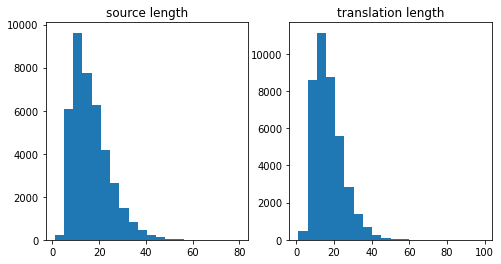

In [17]:
src_length = map(len, [vars(x)['src'] for x in train_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in train_data.examples])

print('Length distribution in Train data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

Length distribution in Test data


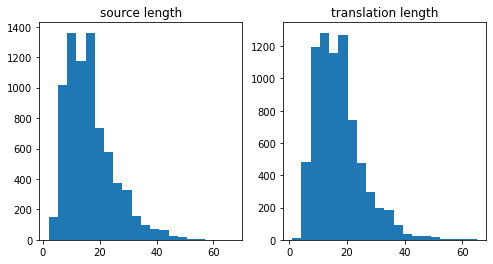

In [16]:
src_length = map(len, [vars(x)['src'] for x in test_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in test_data.examples])

print('Length distribution in Test data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [19]:
def _len_sort_key(x):
    return len(x.src)

BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

In [20]:
for x in train_iterator:
    break
print(x)
print(x.src.shape, x.trg.shape)


[torchtext.legacy.data.batch.Batch of size 128]
	[.trg]:[torch.LongTensor of size 40x128]
	[.src]:[torch.LongTensor of size 44x128]
torch.Size([44, 128]) torch.Size([40, 128])


In [21]:
import random
import math
import time


class Encoder(nn.Module):
    def __init__(self,
                 input_dim,
                 emb_dim,
                 hid_dim,
                 n_layers, 
                 dropout):
        super().__init__()
        
        self.input_dim = input_dim
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
#         self.dropout = dropout
        
        self.embedding = nn.Embedding(
            num_embeddings=input_dim,
            embedding_dim=emb_dim
        )
            # <YOUR CODE HERE>
        
        self.rnn = nn.LSTM(
            input_size=emb_dim,
            hidden_size=hid_dim,
            num_layers=n_layers,
            dropout=dropout
        )
            # <YOUR CODE HERE>
        
        self.dropout = nn.Dropout(p=dropout)# <YOUR CODE HERE>
        
    def forward(self, src):
        
        #src = [src sent len, batch size]
        
        # Compute an embedding from the src data and apply dropout to it
        embedded = self.embedding(src)# <YOUR CODE HERE>
        
        embedded = self.dropout(embedded)
        
        output, (hidden, cell) = self.rnn(embedded)
        #embedded = [src sent len, batch size, emb dim]
        
        # Compute the RNN output values of the encoder RNN. 
        # outputs, hidden and cell should be initialized here. Refer to nn.LSTM docs ;)
        
        # <YOUR CODE HERE>         
        #outputs = [src sent len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #outputs are always from the top hidden layer
        
        return hidden, cell
    

class Decoder(nn.Module):
    def __init__(self, 
                 output_dim,   # all the same as in the encoder except this parameter 
                 emb_dim, 
                 hid_dim, 
                 n_layers, 
                 dropout):
        super().__init__()

        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.output_dim = output_dim
        self.n_layers = n_layers
        self.dropout = dropout
        
        self.embedding = nn.Embedding(
            num_embeddings=output_dim,
            embedding_dim=emb_dim
        )
            # <YOUR CODE HERE>
        
        self.rnn = nn.LSTM(
            input_size=emb_dim,
            hidden_size=hid_dim,
            num_layers=n_layers,
            dropout=dropout
        )
            # <YOUR CODE HERE>
        
        self.out = nn.Linear(
            in_features=hid_dim,
            out_features=output_dim
        )
            # <YOUR CODE HERE>
        
        self.dropout = nn.Dropout(p=dropout)# <YOUR CODE HERE>
        
    def forward(self, input, hidden, cell):
        
        #input = [batch size]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #n directions in the decoder will both always be 1, therefore:
        #hidden = [n layers, batch size, hid dim]
        #context = [n layers, batch size, hid dim]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        # Compute an embedding from the input data and apply dropout to it
        embedded = self.dropout(self.embedding(input))# <YOUR CODE HERE>
        
        #embedded = [1, batch size, emb dim]
        
        # Compute the RNN output values of the encoder RNN. 
        # outputs, hidden and cell should be initialized here. Refer to nn.LSTM docs ;)
        # <YOUR CODE HERE>        
        
        #output = [sent len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #sent len and n directions will always be 1 in the decoder, therefore:
        #output = [1, batch size, hid dim]
        #hidden = [n layers, batch size, hid dim]
        #cell = [n layers, batch size, hid dim]        
        
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        prediction = self.out(output.squeeze(0))        
        #prediction = [batch size, output dim]
        
        return prediction, hidden, cell


class Seq2Seq(nn.Module):
    def __init__(self, 
                 encoder, 
                 decoder, 
                 device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"
        
    def forward(self, 
                src,
                trg, 
                teacher_forcing_ratio = 0.5):
        
        #src = [src sent len, batch size]
        #trg = [trg sent len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        
        # Again, now batch is the first dimention instead of zero
        batch_size = trg.shape[1]
        max_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(max_len, 
                              batch_size, 
                              trg_vocab_size).to(self.device)
        
        #last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(src)
        
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        for t in range(1, max_len):            
            output, hidden, cell = self.decoder(input,
                                                hidden,
                                                cell)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.max(1)[1]
            input = (trg[t] if teacher_force else top1)
        
        return outputs


In [22]:
Encoder = Encoder
Decoder = Decoder
Seq2Seq = Seq2Seq

In [23]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)
# dont forget to put the model to the right device
model = Seq2Seq(enc, dec, device).to(device)

In [24]:
def init_weights(m):
    # <YOUR CODE HERE>
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(9268, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(6702, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (out): Linear(in_features=512, out_features=6702, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [25]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 14,882,862 trainable parameters


In [26]:
PAD_IDX = TRG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [27]:
def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):        
        src = batch.src
        trg = batch.trg   

        optimizer.zero_grad()        
        output = model(src, trg)        
        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]        
        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)        
        #trg = [(trg sent len - 1) * batch size]
        #output = [(trg sent len - 1) * batch size, output dim]        
        
        loss = criterion(output, trg)        
        loss.backward()  

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)   # Let's clip the gradient 

        optimizer.step()        
        epoch_loss += loss.item()        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()            
            plt.show()      
              
    return epoch_loss / len(iterator)

In [28]:
def evaluate(model, iterator, criterion):    
    model.eval()    
    epoch_loss = 0    
    history = []    
    with torch.no_grad():    
        for i, batch in enumerate(iterator):
            src = batch.src
            trg = batch.trg
            output = model(src, trg, 0) #turn off teacher forcing
            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]
            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)
            #trg = [(trg sent len - 1) * batch size]
            #output = [(trg sent len - 1) * batch size, output dim]
            loss = criterion(output, trg)            
            epoch_loss += loss.item()
                    
    return epoch_loss / len(iterator)

In [29]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [30]:
train_history = []
valid_history = []
N_EPOCHS = 10
CLIP = 1
best_valid_loss = float('inf')

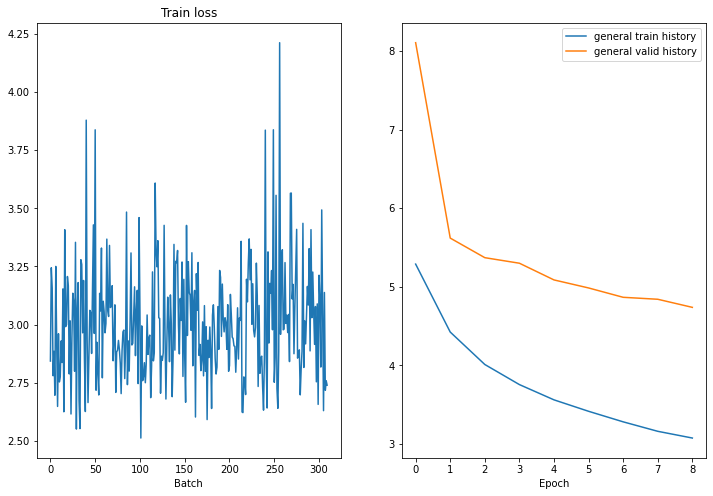

Epoch: 10 | Time: 1m 46s
	Train Loss: 3.003 | Train PPL:  20.140
	 Val. Loss: 4.824 |  Val. PPL: 124.487


In [30]:
for epoch in range(N_EPOCHS):    
    start_time = time.time()    
    train_loss = train(model,
                       train_iterator,
                       optimizer,
                       criterion,
                       CLIP,
                       train_history,
                       valid_history)
    valid_loss = evaluate(model,
                          valid_iterator,
                          criterion)
    
    end_time = time.time()    
    epoch_mins, epoch_secs = epoch_time(start_time,
                                        end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [31]:
def flatten(l):
    return [item for sublist in l for item in sublist]

def remove_tech_tokens(mystr,
                       tokens_to_remove=['<eos>', '<sos>', '<unk>', '<pad>']):
    return [x for x in mystr if x not in tokens_to_remove]


def get_text(x, TRG_vocab):
    text = [TRG_vocab.itos[token] for token in x]
    try:
        end_idx = text.index('<eos>')
        text = text[:end_idx]
    except ValueError:
        pass
    text = remove_tech_tokens(text)
    if len(text) < 1:
        text = []
    return text

def generate_translation(src,
                         trg,
                         model,
                         TRG_vocab):
    model.eval()

    output = model(src, trg, 0) #turn off teacher forcing
    output = output.argmax(dim=-1).cpu().numpy()

    original = get_text(list(trg[:,0].cpu().numpy()),
                        TRG_vocab)
    generated = get_text(list(output[1:, 0]),
                         TRG_vocab)
    
    print('Original: {}'.format(' '.join(original)))
    print('Generated: {}'.format(' '.join(generated)))
    print()

In [32]:
##del utils
#i#mport utils
#import imp
#imp.reload(utils)
#generate_translation = utils.generate_translation
#remove_tech_tokens = utils.remove_tech_tokens
#get_text = utils.get_text
#flatten = utils.flatten

In [32]:
batch = next(iter(test_iterator))

In [33]:
for idx in [1,2]:
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src,
                         trg,
                         model,
                         TRG.vocab)

Original: massages can be arranged .
Generated: originally originally compostela cash cash cash cash cash cash cash elmas elmas elmas elmas

Original: a 24 - hour reception is available .
Generated: originally originally compostela cash cash cash cash cash cash cash elmas elmas elmas elmas



In [34]:
from nltk.translate.bleu_score import corpus_bleu
#     """ Estimates corpora-level BLEU score of model's translations given inp and reference out """
#     translations, _ = model.translate_lines(inp_lines, **flags)
#     # Note: if you experience out-of-memory error, split input lines into batches and translate separately
#     return corpus_bleu([[ref] for ref in out_lines], translations) * 100

In [35]:
import tqdm

In [37]:
original_text = []
generated_text = []
model.eval()
with torch.no_grad():
    for i, batch in tqdm.tqdm(enumerate(test_iterator)):
        src = batch.src
        trg = batch.trg
        output = model(src,
                       trg,
                       0) #turn off teacher forcing
        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]
        output = output.argmax(dim=-1)        
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])

# original_text = flatten(original_text)
# generated_text = flatten(generated_text)

59it [00:04, 13.82it/s]


In [38]:
corpus_bleu([[text] for text in original_text],
            generated_text
            ) * 100

13.642006034400818

In [36]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive




Baseline solution BLEU score is quite low. Try to achieve at least 18 BLEU on the test set. The checkpoints are:

    18 - minimal score to submit the homework, 30% of points

    20 - good score, 70% of points

    25 - excellent score, 100% of points



preprocessing module->

In [37]:
! pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 7.5 MB/s 
     |████████████████████████████████| 86 kB 4.9 MB/s 
     |████████████████████████████████| 6.6 MB 36.8 MB/s 
     |████████████████████████████████| 596 kB 42.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [38]:
from torchtext.legacy.data import Field, TabularDataset
from nltk.tokenize import WordPunctTokenizer
from transformers import AutoTokenizer

import random

tokenizer_W = WordPunctTokenizer()

def tokenize(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())

def tokenize_reverse(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())[:-1]

def process_dataset(path_to_data, reverse_trg=False, bf=False):
    SRC = Field(tokenize=tokenize, 
                init_token = '<sos>', eos_token = '<eos>', lower = True, batch_first=bf) # , batch_first = True
    
    if reverse_trg:
        TRG = Field(tokenize=tokenize_reverse,
                init_token = '<sos>',  eos_token = '<eos>', lower = True, batch_first=bf)
    else:
        TRG = Field(tokenize=tokenize,
                init_token = '<sos>',  eos_token = '<eos>', lower = True, batch_first=bf)
    
    # fixing seed for reproducibility
    random.seed(420)
    dataset = TabularDataset(
        path=path_to_data, format='tsv', fields=[('trg', TRG), ('src', SRC)]
    )
    
    train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])
    print(f"Number of training examples: {len(train_data.examples)}")
    print(f"Number of validation examples: {len(valid_data.examples)}")
    print(f"Number of testing examples: {len(test_data.examples)}")
    
    SRC.build_vocab(train_data, min_freq = 3)
    TRG.build_vocab(train_data, min_freq = 3)
    print(f"Unique tokens in source (ru) vocabulary: {len(SRC.vocab)}")
    print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")
    
    return train_data, valid_data, test_data, SRC, TRG


Downloading:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/642 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.57M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
# from utils.py

In [40]:
def flatten(l):
    return [item for sublist in l for item in sublist]

def remove_tech_tokens(mystr, tokens_to_remove=['<eos>', '<sos>', '<unk>', '<pad>']):
    return [x for x in mystr if x not in tokens_to_remove]


def get_text(x, TRG_vocab):
    text = [TRG_vocab.itos[token] for token in x]
    try:
        end_idx = text.index('<eos>')
        text = text[:end_idx]
    except ValueError:
        pass
    text = remove_tech_tokens(text)
    if len(text) < 1:
        text = []
    return text


def translate_sentence_vectorized(src_tensor, trg_field, model, device, max_len=50):
    assert isinstance(src_tensor, torch.Tensor)

    model.eval()
    src_mask = model.make_src_mask(src_tensor)

    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)
    # enc_src = [batch_sz, src_len, hid_dim]

    trg_indexes = [[trg_field.vocab.stoi[trg_field.init_token]] for _ in range(len(src_tensor))]
    # Even though some examples might have been completed by producing a <eos> token
    # we still need to feed them through the model because other are not yet finished
    # and all examples act as a batch. Once every single sentence prediction encounters
    # <eos> token, then we can stop predicting.
    translations_done = [0] * len(src_tensor)
    for i in range(max_len):
        trg_tensor = torch.LongTensor(trg_indexes).to(device)
        trg_mask = model.make_trg_mask(trg_tensor)
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        pred_tokens = output.argmax(2)[:,-1]
        for i, pred_token_i in enumerate(pred_tokens):
            trg_indexes[i].append(pred_token_i)
            if pred_token_i == trg_field.vocab.stoi[trg_field.eos_token]:
                translations_done[i] = 1
        if all(translations_done):
            break

    # Iterate through each predicted example one by one;
    # Cut-off the portion including the after the <eos> token
    pred_sentences = []
    for trg_sentence in trg_indexes:
        pred_sentence = []
        for i in range(1, len(trg_sentence)):
            if trg_sentence[i] == trg_field.vocab.stoi[trg_field.eos_token]:
                break
            pred_sentence.append(trg_field.vocab.itos[trg_sentence[i]])
        pred_sentence = remove_tech_tokens(pred_sentence)
        pred_sentences.append(pred_sentence)

    return pred_sentences, attention


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
     

In [41]:
# some more utils
def bleu_score(model, test_iterator, TRG, transformer=False): # 
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    original_text = []
    generated_text = []
    model.eval()
    with torch.no_grad():
        for i, batch in tqdm.tqdm(enumerate(test_iterator)):
            src = batch.src
            trg = batch.trg
            if transformer:
                translation, _ = translate_sentence_vectorized(src, TRG, model, device)
                generated_text.extend(translation)
                original_text.extend([get_text(x, TRG.vocab) for x in trg])
            else:
                output = model(src, trg, 0) #turn off teacher forcing   
                output = output.argmax(dim=-1)
                generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])
                original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])            
            
    score = corpus_bleu([[text] for text in original_text], generated_text) * 100
    return score, original_text, generated_text


def show_results(model, test_iterator, TRG, tr_flag=False, num_examples=5): 
    print(f'The model has {count_parameters(model):,} trainable parameters')
    score, original_text, generated_text = bleu_score(model, test_iterator, TRG, transformer=tr_flag) 
    print('BLEU:', score)
    print()
    for _ in range(num_examples):
        index = random.randint(0, len(original_text))
        print('original:', ' '.join(original_text[index]))
        print('translated:', ' '.join(generated_text[index]))
        print() 

## Model 1. GRU 

In [42]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/nlp_lab2')

In [46]:
from models import GRU  # module contains all models 

In [47]:
import train  # module that can train different models

In [48]:
train_data, valid_data, test_data, SRC, TRG = process_dataset(path_to_data, reverse_trg=True)

Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500
Unique tokens in source (ru) vocabulary: 9261
Unique tokens in target (en) vocabulary: 6702


In [49]:
gru_rev_model, test_iterator =  train.train_model(train_data,
                                                  valid_data,
                                                  test_data, 
                                                  SRC,
                                                  TRG,
                                                  GRU,
                                                  'GRU_12_epoch_reversed',
                                                  batch_size=128,
                                                  n_epochs=12)

training on cpu


0it [00:13, ?it/s]


KeyboardInterrupt: ignored

In [50]:
show_results(gru_rev_model, test_iterator, TRG)

NameError: ignored

In [51]:
train.load_best_model('GRU_12_epoch_reversed',
                      GRU,
                      SRC,
                      TRG,
                      test_iterator)

RuntimeError: ignored

The result is not good enough. Overfitting is observed in train-valid picture.

##Model 2. GRU with Attention

In [52]:
train_data, valid_data, test_data, SRC, TRG = process_dataset(path_to_data)

Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500
Unique tokens in source (ru) vocabulary: 9261
Unique tokens in target (en) vocabulary: 6703


In [53]:
from models import GRU_attention  # module contains all models

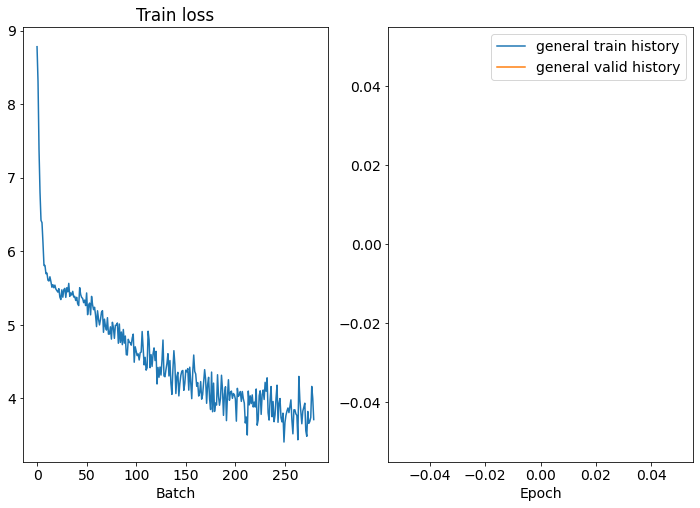

289it [1:11:57, 14.16s/it]

In [ ]:
gru_attention_model, test_iterator = train.train_model(train_data,
                                                 valid_data,
                                                 test_data,
                                                 SRC,
                                                 TRG,
                                                 GRU_attention,
                                                 'GRU_attention_10_epoch',
                                                 batch_size=128,
                                                 n_epochs=10)

In [ ]:
show_results(gru_attention_model,
             test_iterator,
             TRG)

In [ ]:
train.load_best_model('GRU_attention_10_epoch',
                      GRU_attention,
                      SRC,
                      TRG,
                      test_iterator)

The quality of 28 BLEU is quite good.

## Model 3. Transformer

In [ ]:
train_data, valid_data, test_data, SRC, TRG = process_dataset(path_to_data, bf=True)

In [ ]:
from models import transformer  # module contains all models 

In [ ]:
transformer_model, test_iterator = train.train_transformer(train_data,
                                                           valid_data,
                                                           test_data,
                                                           SRC,
                                                           TRG,
                                                           transformer,
                                                           'transformer_10_epoch_4heads',
                                                           batch_size=128,
                                                           n_epochs=10)

In [ ]:
show_results(transformer_model, test_iterator, TRG, tr_flag=True)

In [ ]:
train.load_best_model('transformer_10_epoch_4heads', transformer, SRC, TRG, test_iterator, transformer=True)

BLEU: 32.9 is enough, no more experiments needed)

Unfortunately, this workbook was restarted and almost all cells results were erased. But main conclusions are still valid. As soon as google colab permits to use their GPU this workbook will be renewed. On Cpu it's impossible to train models..